# Import libraries and Data

In [1]:
# import libraries
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
%matplotlib inline

In [3]:
# Import data frames
path = r'G:\Career Foundery\CFundry-6\2 Data set'
energy_consump = pd.read_pickle(os.path.join(path, 'Modified', 'energy_consumption.pkl'))
elect_prod = pd.read_pickle(os.path.join(path, 'Modified', 'elect_production.pkl'))
euro_gdp = pd.read_pickle(os.path.join(path, 'Modified', 'euro_gdp.pkl'))
euro_pop = pd.read_pickle(os.path.join(path, 'Modified', 'euro_population.pkl'))
euro_area = pd.read_pickle(os.path.join(path, 'Modified', 'euro_area.pkl'))

### Prepare electricity consumption table 

In [4]:
# extract the annual electricity consumption from all energy types
elect_consumption = energy_consump[energy_consump['energy-type']=='Electricity']
# add all consumption sectors to obtain total electricity consumption
elect_consumption_total = elect_consumption.groupby(['country', 'time-period'], as_index=False)['value(KTOE)'].sum()
#rename the columns
elect_consumption_total.rename(columns={'time-period':'year', 'value(KTOE)':'elect-consump(KTOE)'}, inplace=True)
elect_consumption_total

,country,year,elect-consump(KTOE)
0,Albania,2009,389.080
1,Albania,2010,414.789
2,Albania,2011,435.254
3,Albania,2012,478.333
4,Albania,2013,578.418
...,...,...,...
464,United Kingdom,2015,25758.055
465,United Kingdom,2016,25792.232
466,United Kingdom,2017,25409.908
467,United Kingdom,2018,25493.085


### Prepare GDP table

In [5]:
# GDP dataframe
# split the time period in year and quarter
euro_gdp['year'] = np.array(euro_gdp['time-period'].str.split('-').tolist())[:,0].tolist()
euro_gdp['quarter'] = np.array(euro_gdp['time-period'].str.split('-').tolist())[:,1].tolist()
# add quarter gdp to get the annual values
euro_gdp_annual = euro_gdp.groupby(['country', 'year'], as_index=False)['GDP(mm-euro)'].sum()
# change the data type for year
euro_gdp_annual['year'] = euro_gdp_annual['year'].astype('int64')
euro_gdp_annual

,country,year,GDP(mm-euro)
0,Austria,1995,241446.2
1,Austria,1996,246899.1
2,Austria,1997,252331.0
3,Austria,1998,261172.9
4,Austria,1999,270025.3
...,...,...,...
1003,United Kingdom,2016,2690268.6
1004,United Kingdom,2017,2737087.7
1005,United Kingdom,2018,2771372.3
1006,United Kingdom,2019,2811121.0


### Prepare population table

In [7]:
euro_pop.rename(columns={'time-period':'year'}, inplace=True)
euro_pop

,country,year,population
0,Andorra,1986,44593.0
1,Andorra,1987,46976.0
2,Andorra,1988,48451.0
3,Andorra,1989,50528.0
4,Andorra,1990,50887.0
...,...,...,...
2407,Kosovo,2016,1771604.0
2408,Kosovo,2017,1783531.0
2409,Kosovo,2018,1798506.0
2410,Kosovo,2019,1795666.0


### Join all tables 

In [8]:
df1 = elect_consumption_total.merge(euro_pop, on=['country', 'year'], how='inner')
df2 = df1.merge(euro_area, on='country', how='inner' )
df3 = df2.merge(euro_gdp_annual, on=['country', 'year'], how='inner')
df3

,country,year,elect-consump(KTOE),population,area(Km^2),GDP(mm-euro)
0,Austria,2009,4821.631,8335003.0,83871.0,320314.1
1,Austria,2010,5054.828,8351643.0,83871.0,325845.0
2,Austria,2011,5053.536,8375164.0,83871.0,335807.9
3,Austria,2012,5131.961,8408121.0,83871.0,338350.2
4,Austria,2013,5159.144,8451860.0,83871.0,338257.8
...,...,...,...,...,...,...
354,United Kingdom,2015,25758.055,64853393.0,243610.0,2644716.5
355,United Kingdom,2016,25792.232,65379044.0,243610.0,2690268.6
356,United Kingdom,2017,25409.908,65844142.0,243610.0,2737087.7
357,United Kingdom,2018,25493.085,66273576.0,243610.0,2771372.3


In [10]:
# missing value
df3.isnull().sum()

country                0
year                   0
elect-consump(KTOE)    0
population             0
area(Km^2)             0
GDP(mm-euro)           0
dtype: int64

In [11]:
df3[df3.duplicated()]

,country,year,elect-consump(KTOE),population,area(Km^2),GDP(mm-euro)


<AxesSubplot:xlabel='elect-consump(KTOE)', ylabel='Count'>

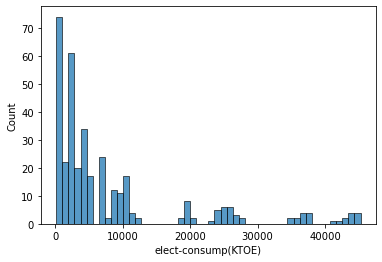

In [13]:
sns.histplot(df3['elect-consump(KTOE)'], bins=50)

### As we have countries with different demographic and economic situations there are separate groups in histogram of electricity consumption. But we cannot remove any of them as outlier because they are valid inforamtion for different countries. 

In [14]:
df3['elect-consump(KTOE)'].min()

146.689

In [15]:
df3['elect-consump(KTOE)'].max()

45242.132

In [16]:
df3['elect-consump(KTOE)'].mean()

8130.755757660166

In [17]:
df3['elect-consump(KTOE)'].median()

3814.962

### Data preparation for regression

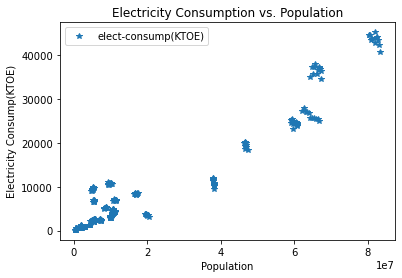

In [19]:
# create scatterplot to show the relation between population and electricity consumption
df3.plot(x='population', y='elect-consump(KTOE)', style='*')
plt.title('Electricity Consumption vs. Population')
plt.xlabel('Population')
plt.ylabel('Electricity Consump(KTOE)')
plt.show()

#### This graph suggests a linear positive correlation between these variables

In [20]:
# reshape the variable for regression analysis
X = df3['population'].values.reshape(-1,1)
y = df3['elect-consump(KTOE)'].values.reshape(-1,1)

In [21]:
X

array([[ 8335003.],
       [ 8351643.],
       [ 8375164.],
       [ 8408121.],
       [ 8451860.],
       [ 8507786.],
       [ 8584926.],
       [ 8700471.],
       [ 8772865.],
       [ 8822267.],
       [ 8858775.],
       [ 8901064.],
       [10753080.],
       [10839905.],
       [11000638.],
       [11075889.],
       [11137974.],
       [11180840.],
       [11237274.],
       [11311117.],
       [11351727.],
       [11398589.],
       [11455519.],
       [11522440.],
       [ 7467119.],
       [ 7421766.],
       [ 7369431.],
       [ 7327224.],
       [ 7284552.],
       [ 7245677.],
       [ 7202198.],
       [ 7153784.],
       [ 7101859.],
       [ 7050034.],
       [ 7000039.],
       [ 6951482.],
       [ 4309796.],
       [ 4302847.],
       [ 4289857.],
       [ 4275984.],
       [ 4262140.],
       [ 4246809.],
       [ 4225316.],
       [ 4190669.],
       [ 4154213.],
       [ 4105493.],
       [ 4076246.],
       [ 4058165.],
       [10425783.],
       [10462088.],


In [22]:
y

array([[ 4821.631],
       [ 5054.828],
       [ 5053.536],
       [ 5131.961],
       [ 5159.144],
       [ 5082.602],
       [ 5162.034],
       [ 5242.579],
       [ 5323.258],
       [ 5354.708],
       [ 5357.687],
       [ 5161.098],
       [ 6694.489],
       [ 7206.596],
       [ 7034.419],
       [ 7005.167],
       [ 7009.776],
       [ 6847.859],
       [ 6878.048],
       [ 6919.845],
       [ 6924.523],
       [ 6970.534],
       [ 6886.123],
       [ 6645.976],
       [ 2293.466],
       [ 2317.628],
       [ 2426.655],
       [ 2374.634],
       [ 2350.129],
       [ 2366.208],
       [ 2421.238],
       [ 2470.335],
       [ 2557.082],
       [ 2550.691],
       [ 2564.387],
       [ 2429.649],
       [ 1320.826],
       [ 1351.237],
       [ 1340.18 ],
       [ 1307.889],
       [ 1284.049],
       [ 1263.181],
       [ 1307.102],
       [ 1303.28 ],
       [ 1361.728],
       [ 1378.1  ],
       [ 1376.444],
       [ 1295.537],
       [ 4494.067],
       [ 4589.338],


In [23]:
# split data set into test and training groups
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) 

### Regression Analysis

In [24]:
# creayte linear regression object
regressionSingle = LinearRegression()

# fit the regression model with training dataset
regressionSingle.fit(X_train, y_train)

# predict y value using X_test
y_predicted = regressionSingle.predict(X_test)


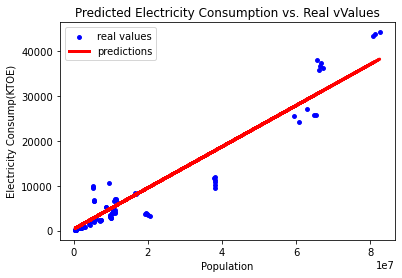

In [28]:
# plot the regression line vs real values
plot_test = plt
plot_test.scatter(X_test, y_test, color='blue', s=15, label='real values')
plot_test.plot(X_test, y_predicted, color='red', linewidth=3, label='predictions')
plot_test.title('Predicted Electricity Consumption vs. Real vValues')
plot_test.xlabel('Population')
plot_test.ylabel('Electricity Consump(KTOE)')
plot_test.legend()
plot_test.show()

In [29]:
# Create modelling summary statistics
mse = mean_squared_error(y_test, y_predicted)
r2 = r2_score(y_test, y_predicted)

In [35]:
# print the metrics
print('slope: ', regressionSingle.coef_)
print('mse: ', mse**0.5)
print('r2: ', r2)

slope:  [[0.00045891]]
mse:  3211.8466848037133
r2:  0.9088229487708759


In [36]:
# compare actual and predicted values for electricity consumption
data = pd.DataFrame({'Actual':y_test.flatten(), 'Predictions':y_predicted.flatten()})
data

,Actual,Predictions
0,5162.034,4281.357912
1,11283.792,17765.248946
2,36319.509,31170.273149
3,199.185,577.769535
4,6618.401,2852.684534
...,...,...
103,3912.767,5087.393309
104,43469.820,37406.811897
105,37261.626,30922.806986
106,25758.055,30103.649451


#### The results shows that while the R2 is 90% and it shows a good correlation between actual and predicted values but the mse is around 3211 which is not a small error for this prediction as the mean value of our dependant variable is around 8130. As the linearity of relation is somehow obvious maybe we have to get help from other independant variables to make a more accurate prediction.

### Compare for the training data set

In [37]:
y_predicted_train = regressionSingle.predict(X_train)
mse = mean_squared_error(y_train, y_predicted_train)
r2 = r2_score(y_train, y_predicted_train)

In [38]:
print('slope: ', regressionSingle.coef_)
print('mse: ', mse**0.5)
print('r2: ', r2)

slope:  [[0.00045891]]
mse:  3130.3294869379797
r2:  0.9171641716531794


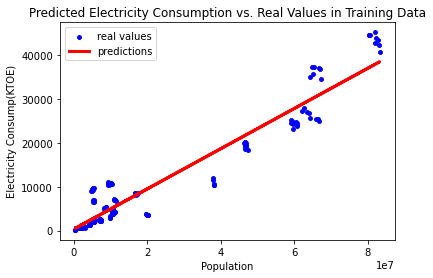

In [39]:
# plot the regression line vs real values for training set
plot_training = plt
plot_training.scatter(X_train, y_train, color='blue', s=15, label='real values')
plot_training.plot(X_train, y_predicted_train, color='red', linewidth=3, label='predictions')
plot_training.title('Predicted Electricity Consumption vs. Real Values in Training Data')
plot_training.xlabel('Population')
plot_training.ylabel('Electricity Consump(KTOE)')
plot_training.legend()
plot_training.show()

#### The metrics of regression analysis for training dataset shows that we have a slightly better accuracy in training set which is also expected what the level of accuracy is not that high to suggest 'overfitting'. Therefore, we suggest for a better prediction use other independant variable to predict electricitu consumption. 

## Multivariable regression 

In [47]:
# reshape the variable for regression analysis
X_mult = df3[['population', 'area(Km^2)','GDP(mm-euro)']].values
y = df3['elect-consump(KTOE)'].values.reshape(-1,1)

In [48]:
X_mult

array([[ 8335003. ,    83871. ,   320314.1],
       [ 8351643. ,    83871. ,   325845. ],
       [ 8375164. ,    83871. ,   335807.9],
       ...,
       [65844142. ,   243610. ,  2737087.7],
       [66273576. ,   243610. ,  2771372.3],
       [66647112. ,   243610. ,  2811121. ]])

In [49]:
y 

array([[ 4821.631],
       [ 5054.828],
       [ 5053.536],
       [ 5131.961],
       [ 5159.144],
       [ 5082.602],
       [ 5162.034],
       [ 5242.579],
       [ 5323.258],
       [ 5354.708],
       [ 5357.687],
       [ 5161.098],
       [ 6694.489],
       [ 7206.596],
       [ 7034.419],
       [ 7005.167],
       [ 7009.776],
       [ 6847.859],
       [ 6878.048],
       [ 6919.845],
       [ 6924.523],
       [ 6970.534],
       [ 6886.123],
       [ 6645.976],
       [ 2293.466],
       [ 2317.628],
       [ 2426.655],
       [ 2374.634],
       [ 2350.129],
       [ 2366.208],
       [ 2421.238],
       [ 2470.335],
       [ 2557.082],
       [ 2550.691],
       [ 2564.387],
       [ 2429.649],
       [ 1320.826],
       [ 1351.237],
       [ 1340.18 ],
       [ 1307.889],
       [ 1284.049],
       [ 1263.181],
       [ 1307.102],
       [ 1303.28 ],
       [ 1361.728],
       [ 1378.1  ],
       [ 1376.444],
       [ 1295.537],
       [ 4494.067],
       [ 4589.338],


In [50]:
# split data set into test and training groups
X_mult_train, X_mult_test, y_train, y_test = train_test_split(X_mult, y, test_size=0.3, random_state=0) 

In [51]:
# creayte multivariable regression object
regressionMult = LinearRegression()

# fit the regression model with training dataset
regressionMult.fit(X_mult_train, y_train)

# predict y value using X_test
y_predicted = regressionMult.predict(X_mult_test)

In [52]:
# Create modelling summary statistics
mse_mult = mean_squared_error(y_test, y_predicted)
r2_mult = r2_score(y_test, y_predicted)

In [53]:
# print the metrics
print('slope: ', regressionMult.coef_)
print('mse-mult: ', mse_mult**0.5)
print('r2-mult: ', r2_mult)

slope:  [[8.42612025e-05 1.43101311e-02 9.20851616e-03]]
mse-mult:  1649.6568992910268
r2-mult:  0.975947335962527


In [55]:
# compare actual and predicted values for electricity consumption
data_multi = pd.DataFrame({'Actual':y_test.flatten(), 'Predictions':y_predicted.flatten()})
data_multi

,Actual,Predictions
0,5162.034,4797.206163
1,11283.792,11462.216151
2,36319.509,36315.647303
3,199.185,-139.875652
4,6618.401,6949.812210
...,...,...
103,3912.767,3580.819511
104,43469.820,39118.787508
105,37261.626,34985.519651
106,25758.055,33007.944813


### This analysis shows that adding two other independant variables (area & GDP) make the prediction more accurate and acceptaple as the R2 has increased fro 90% to 97.5% and also the RMSE has increase from 3211 to 1649. We can suggest that in this case using multivariable regression can decrease single-variable model error about 50% which is actually noticable in a simple regression problem. 

### Data biases that can be included in this data set may come from data gathering section while more developed countries which have in general higher GDP and also higher electricity consumption prepare more frequency and probably more accurate information. Therefore, it is possible that for low GDP, low electricity consumer countries information is not accurate and it brings some inaccuracies in prediction models. Also, I think in multivariable analysis the independant variables are not completely independant as greater available land can cause more population for bigger countries and having bigger country with highre work-force and probably more natural resources may also cause higher GDPs. 